Number of training samples: 10616
Unique data providers: 2
Unique ISUP grades: [0 4 1 3 5 2]
Unique Gleason scores: ['0+0' '4+4' '3+3' '4+3' 'negative' '4+5' '3+4' '5+4' '5+5' '5+3' '3+5']
Missing values in the dataset:
image_id         0
data_provider    0
isup_grade       0
gleason_score    0
dtype: int64
Number of images without masks: 100
Training data shape after removing entries without masks: 10516


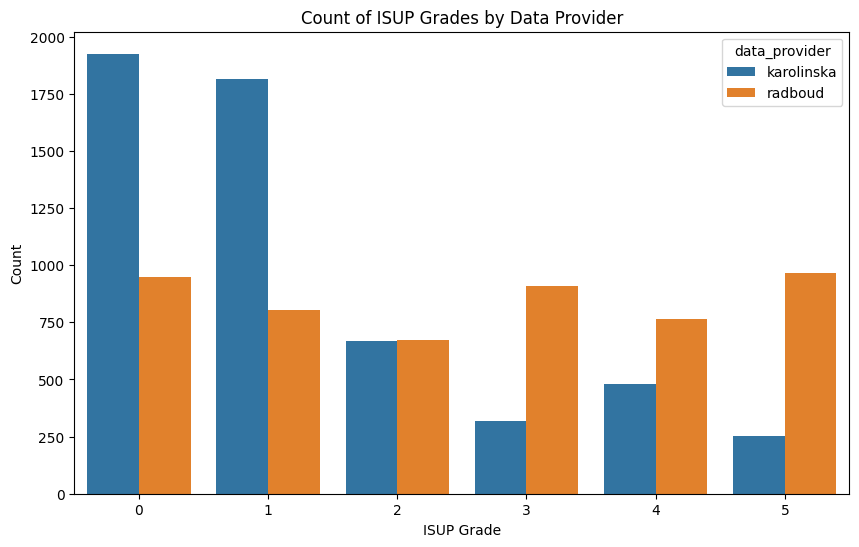

  0%|          | 0/10516 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [24]:
import os
import numpy as np  
import pandas as pd 

from skimage import io as skio 
import cv2 
from tqdm.notebook import tqdm 

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Define the data path
DATA_PATH = "../input/prostate-cancer-grade-assessment/"

# Load the training and test datasets
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

# Display first few rows of the training data
train_df.head().style.set_caption('Overview of Training Data')

# Print basic information about the training dataset
print(f"Number of training samples: {train_df.shape[0]}")
print(f"Unique data providers: {train_df['data_provider'].nunique()}")
print(f"Unique ISUP grades: {train_df['isup_grade'].unique()}")
print(f"Unique Gleason scores: {train_df['gleason_score'].unique()}")

# Check for missing values in the training data
print(f"Missing values in the dataset:\n{train_df.isna().sum()}")

# List mask and image files
mask_files = os.listdir(os.path.join(DATA_PATH, 'train_label_masks'))
image_files = os.listdir(os.path.join(DATA_PATH, 'train_images'))

# Create a DataFrame for mask files
mask_df = pd.DataFrame(mask_files, columns=['mask_file_name'])
mask_df['image_id'] = mask_df['mask_file_name'].apply(lambda x: x.split('_')[0])
train_df = train_df.merge(mask_df, on='image_id', how='outer')

# Display the count of images without masks
print(f"Number of images without masks: {train_df['mask_file_name'].isna().sum()}")

# Reduce the training data to those with masks
train_df_with_masks = train_df.dropna(subset=['mask_file_name'])
print(f"Training data shape after removing entries without masks: {train_df_with_masks.shape[0]}")

# Analysis of ISUP grade to Gleason score mapping
train_df_with_masks.groupby('isup_grade')['gleason_score'].unique().to_frame().style.set_caption('ISUP Grade to Gleason Score Mapping')

# Plot the count of ISUP grades by data provider
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df_with_masks, x='isup_grade', hue='data_provider')
plt.title('Count of ISUP Grades by Data Provider')
plt.xlabel('ISUP Grade')
plt.ylabel('Count')
plt.show()

# Initialize columns for tissue labels
labels = [1, 2, 3, 4, 5]
for label in labels:
    train_df_with_masks[label] = 0

# Process the images and count the tissue labels
for idx, row in tqdm(train_df_with_masks.iterrows(), total=len(train_df_with_masks)):
    image_id = row['image_id']
    image_path = os.path.join(DATA_PATH, 'train_label_masks', f"{image_id}_mask.tiff")
    image = skio.MultiImage(image_path)[-1]
    for label in labels:
        train_df_with_masks.at[idx, label] = np.sum(image == label)

# Calculate tissue coverage
train_df_with_masks['tissue'] = train_df_with_masks[labels].sum(axis=1)

# Second reduction of the training dataset
background_only_masks = train_df_with_masks[(train_df_with_masks[1] == 0) & (train_df_with_masks[2] == 0) & (train_df_with_masks[3] == 0) & (train_df_with_masks[4] == 0) & (train_df_with_masks[5] == 0)]
train_df_final = train_df_with_masks[~train_df_with_masks['image_id'].isin(background_only_masks['image_id'])]
print(f"Training data shape after second reduction: {train_df_final.shape[0]}")

# Plotting tissue labels by provider and ISUP grade
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

karolinska_labels = train_df_final[train_df_final['data_provider'] == 'karolinska'].groupby('isup_grade')[[1, 2, 'tissue']].mean()
karolinska_labels[1] = karolinska_labels[1] / karolinska_labels['tissue'] * 100
karolinska_labels[2] = karolinska_labels[2] / karolinska_labels['tissue'] * 100
karolinska_labels.drop(columns=['tissue'], inplace=True)
karolinska_labels.plot(kind='bar', stacked=True, ax=ax1, colormap=mcolors.ListedColormap(['green', 'red']))
ax1.set_title('Karolinska Tissue Labels by ISUP Grade')
ax1.set_xlabel('ISUP Grade')
ax1.set_ylabel('Percentage of Tissue')

radboud_labels = train_df_final[train_df_final['data_provider'] == 'radboud'].groupby('isup_grade')[[1, 2, 3, 4, 5, 'tissue']].mean()
for i in range(1, 6):
    radboud_labels[i] = radboud_labels[i] / radboud_labels['tissue'] * 100
radboud_labels.drop(columns=['tissue'], inplace=True)
radboud_labels.plot(kind='bar', stacked=True, ax=ax2, colormap=mcolors.ListedColormap(['grey', 'green', 'orange', 'red', 'darkred']))
ax2.set_title('Radboud Tissue Labels by ISUP Grade')
ax2.set_xlabel('ISUP Grade')
ax2.set_ylabel('Percentage of Tissue')

plt.show()
